In [1]:
import Pkg; Pkg.add(["Plots","Interact"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; gr(); default(l=5, size=(900,550), label=false);
using Printf;
using Interact;
using SparseArrays;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
    macro manipulate(v)
        return :($v; plot!())
    end
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
function imshowlog(x; kwargs...)
    return heatmap(max.(log.(abs.(x)), log(eps()))
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:linear_worb_100_25_c53_n256)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

### Warmup

In HW4 Q8.(b), you use the Woodbury formula to see that if $A = LL^*$, then

$$
\begin{aligned}
(A + uu^*)^{-1} &= L^{-*}(I + (\tilde{u})(L^{-1} u)^*)^{-1}L^{-1} \\
&= L^{-*}\left(I - \frac{1}{1 + (L^{-1} u)^*(L^{-1} u))}(L^{-1} u)(L^{-1} u)^*\right)L^{-1}
\end{aligned}
$$

How should we compute $(A + uu^*)^{-1}b$,

1. **without** using `inv()`,
2. **minimizing** the number of times we use `L \` or `L' \`

?

In [4]:
#

# The Arnoldi Iteration

**1. Defining the Arnoldi Iteration**

**2. Implementing the Arnoldi Iteration**

**2. Eigenvalue approximation by Arnoldi Iteration**

## Review: Krylov subspaces

$$\large \mathcal{K}_n(A,b) = \mathrm{span}\{b, Ab, A^2 b, \dots, A^{n-1} b\} \quad \text{[subspace]}$$
$$\large K_n(A,b) = [b | Ab | A^2 b | \cdots | A^{n-1} b] \quad \text{[matrix of column vector]}$$

- If we have a  **black-box ~~matrix~~ linear operator** that supplies only matvecs, Krylov subspaces are useful for building $x_k \to x$ such that $Ax = b$

- As we will see today, the subspaces can also be useful for building small matrices with eigenvalues like big matrices

## $K_n(A,b)$ is ill-conditioned

$K_n(A,b)$ records the iterations $v^{(j)}$ of the **unnormalized power iteration** applied to $b$:

- These iterates $v^{(j)} \to \pm v_{\max}$, eigenvectors associated with eigenvalues with largest modulus

- $\frac{v^{(j)*} v^{(j+1)}}{\|v^{(j)}\|\|v^{(j+1)}\|} \to 1$ (subsequent columns are nearly colinear)

- $\mathrm{cond}(K_n) \to \infty$

- $\Rightarrow K_n$ is numerically unstable to use as a basis for $\mathcal{K}_n$

### Motivating definition of the Arnoldi Iteration (but not the way it is computed)

Suppose we compute the QR factorization with $r_{jj}$ real and $r_{jj} \geq 0$

$$\large Q_n R_n = K_n(A, b)$$

- What is $q_1$?

$$q_1 = \frac{b}{\|b\|}$$

- What is the relationship of $Q_{n+1}$ to $Q_n$?

Because $K_{n+1} = [K_n | A^n b]$,

$$Q_{n+1} = \left[\begin{array}{c|c} Q_n & \frac{(I - Q_n Q_n^*) A^n b}{\|(I - Q_n Q_n^*) A^n b \|}\end{array}\right]$$

- Suppose $K_n$ is full rank: what is $A Q_n$?

$$A Q_n = A Q_n R_n R_n^{-1} = A K_n R_n^{-1}$$

$$ = A [ b | A b | A^2 b | \cdots | A^{n-1} b] R_n^{-1}$$

$$ = [ A b | A^2 b | A^3 b | \cdots | A^n b] R_n^{-1}$$

$$= K_{n+1} \begin{bmatrix} 0 \\ \hline I \end{bmatrix} R_n^{-1} = K_{n+1}\begin{bmatrix} 0 \\ \hline R_n^{-1} \end{bmatrix}$$ 

$$= Q_{n+1} \underbrace{R_{n+1} \begin{bmatrix} 0 \\ \hline R_{n}^{-1} \end{bmatrix}}_{???}$$ 

$$
\begin{aligned}
R_{n+1} \begin{bmatrix} 0 \\ \hline R_{n}^{-1} \end{bmatrix} &= 
\begin{bmatrix}
\circ & \bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet & \bullet \\
& & \bullet & \bullet & \bullet \\
& & & \bullet & \bullet \\
& & & & \bullet
\end{bmatrix}
\begin{bmatrix}
\\
\bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet \\
& & \bullet & \bullet \\
& & & \bullet
\end{bmatrix}
\\ 
&=
\begin{bmatrix}
\bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet \\
& & \bullet & \bullet \\
& & & \bullet
\end{bmatrix}
\end{aligned}
$$

- This is **upper Hessenberg**, so we will call it $\tilde{H}_n \in \mathbb{C}^{n+1 \times n}$

### Notation: $H_n$ is the upper square part of $\tilde{H}_n$

$$\tilde{H}_n = \begin{bmatrix}
\bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet \\
& & \bullet & \bullet \\
& & & \bullet
\end{bmatrix}
=
\begin{bmatrix}
\bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet \\
& & \bullet & \bullet \\ \hline
& & & \bullet
\end{bmatrix}
= \begin{bmatrix}
\\
\\
& H_n & \\
\\ 
\\ \hline
\phantom{h_{n+1,n}} & &  h_{n+1,n}
\end{bmatrix}
$$

$$\Large A Q_n = Q_{n+1} \tilde{H}_n$$

- Because we only care about $\tilde{K}_n$ (the subspace) and not $K_n$ (the matrix), **we do not actually need $R_n$**

$$\Large Q_n^* A Q_n = H_n$$

- $H_n$ **is the projection of $A$ into $\tilde{K}_n$**

## The Arnoldi Iteration

**Goal:** Compute $Q_n$ and $H_n$ for $n = 1, \dots$ such that

$$Q_1 = [q_0] = \begin{bmatrix} \frac{b}{\|b\|} \end{bmatrix}$$

$$A Q_n = Q_{n+1} \tilde{H}_n, \quad \text{(upper Hessenberg)}$$

### What about our existing `hessenberg`?

We have an algorithm that computes (by Householder reflectors) $Q$ such that

$$Q^* A Q = H,$$

where $H$ is upper Hessenberg, by Householder reflectors. _Any such $Q$_ has the property that

$$A Q_{:,1:n} = Q_{:,1:n+1} H_{1:n+1,1:n}.$$

So can we use `hessenberg`?

- This algorithm does not have the property that $q_0 = b / \|b\|$.  Using `hessenberg`, $q_0 = e_1$.

### First, unstable version (literal Gram-Schmidt process applied to $K_n$)

Start with $q_0 = b / \|b\|$, $Q_1 = [q_0]$.  Then, at iteration $j = 1, 2, \dots$:

1. Compute the next column, $v = (K_n)_j = A^j b$ (**unstable**)
2. Project out the previous subspace, $q_j = \frac{(I - Q_j Q_j^*)v}{\|(I - Q_j Q_j^*)v\|}, \quad Q_{j+1} = [Q_j | q_{j}]$

- This is numerically unstable for the same reason unnormalized power iteration is unstable, $\mathrm{cond}(A^j) \to \infty$

### Second, generic version

Start with $q_0 = b / \|b\|$, $Q_1 = [q_0]$.  Then, at iteration $j = 1, 2, \dots$:

1. Let $v$ be **any vector in $\mathcal{K}_{j+1} \setminus \mathcal{K}_j$**
2. Project out the previous subspace, $q_j = \frac{(I - Q_j Q_j^*)v}{\|(I - Q_j Q_j^*)v\|}, \quad Q_{j+1} = [Q_j | q_{j}]$

- $v$ does not exist if $\mathcal{K}_{j+1} \setminus \mathcal{K}_j$, but set that corner case aside for now

### Third version, projection unspecified

Start with $q_0 = b / \|b\|$, $Q_1 = [q_0]$.  Then, at iteration $j = 1, 2, \dots$:

1. $v = A q_{j-1}$
2. Project out the previous subspace, $\tilde{q}_j = (I - Q_j Q_j^*)v$
3. $q_j = \tilde{q}_j / \|\tilde{q}_j\| \quad Q_{j+1} = [Q_j | q_{j}]$

- Assuming $\mathcal{K_{j}} \neq \mathcal{K_{j-1}}$, then $q_{j-1} = A^{j-1} b + w$, $w \in K_{j-1}$, so

$$A q_{j-1} = \underbrace{A^{j+1} b}_{\in \mathcal{K}_{j+1} \setminus \mathcal{K}_j} + \underbrace{Aw}_{\in \mathcal{K}_{j}} \in \mathcal{K}_{j+1} \setminus \mathcal{K}_j$$ 

- What about $\tilde{H}$?

$$Q_j^* v = Q_j^* A q_{j-1} = h_{1:j,j}$$

$$h_{j+1,j} = q_j^* A q_{j-1} = q_j^* v = q_j^* \tilde{q}_j = \|\tilde{q}_j\|$$

### Fourth version, still unstable

Start with $q_0 = b / \|b\|$, $Q_1 = [q_0]$.  Then, at iteration $j = 1, 2, \dots$:

1. $v = A q_{j-1}$ (new vector in $\mathcal{K}_{j+1}$)
2. $h_{1:j,j} = Q_j^* v$ (column $j$ of $\tilde{H}$, diagonal and above)
3. $\tilde{q} = v - Q_j h_{1:j,j}$ (make orthogonal to $\mathcal{K}_{j}$)
4. $h_{j+1,j} = \|\tilde{q}_j\|$ (column $j$ of $\tilde{H}$, below the diagonal)
3. $q_j = \tilde{q}_j / h_{j+1,j} \quad Q_{j+1} = [Q_j | q_{j}]$ (normalize)

Why is this still unstable?

- **This is classical Gram-Schmidt: orthogonality will be lost in $Q$**

- Any of the various stable QR orthogonalizations can be adapted to this: if we choose **modified Gram-Schmidt**, it is called the **Arnoldi iteration**

In [5]:
function arnoldi(A, b, n)
    m = size(A)[1]
    @assert n ≤ m
    Q = zeros(eltype(A), m, n+1)
    H̃ = zeros(eltype(A), n+1, n)
    Q[:,1] = b / norm(b)
    for j in 1:n
        v = A * Q[:,j]
        for i in 1:j # modified Gram-Schmidt
            H̃[i,j] = Q[:,i]' * v
            v -= Q[:,i] * H̃[i,j]
        end
        H̃[j+1,j] = norm(v)
        Q[:,j+1] = v / H̃[j+1,j]
    end
    return Q, H̃
end

arnoldi (generic function with 1 method)

In [6]:
m = 50
n = 10
A = randn(m,m)
b = randn(m)
Q, H = arnoldi(A, b, n);

In [7]:
norm(Q[:,1] - b / norm(b))

0.0

In [8]:
norm(H - UpperHessenberg(H))

0.0

In [9]:
norm(I - Q' * Q)

7.507194889317646e-16

In [10]:
norm(A * Q[:,1:n] - Q * H) / norm(A)

1.2959468588584662e-16

### Summarizing

**T&B Theorem 33.1** The matrix $Q_n$ generated by `arnoldi(A, b, n-1)` are reduced QR factors of the Krylov matrix,

$$
Q_n R_n = K_n(A,b).$$

The Hessenberg matrix $H_n = (\tilde{H}_n)_{1:n,1:n}$ is the corresponding projections,

$$H_n = Q_n^* A Q_n,$$

and the successive iterates are related by

$$A Q_n = Q_{n+1} \tilde H_n.$$

### Pre-Exercise: the corner case (a "happy" breakdown)

**T&B Exercise 33.2**  If $h_{n+1,n} = 0$, how does $A Q_n = Q_{n+1} \tilde H_n$ simplify?

As a result:

1. $\mathcal{K}_n$ is $A$-invariant,
2. $\mathcal{K}_{n+j} = \mathcal{K}_n$ for all $j \geq 0$.

### Exercise

If $h_{n+1,n} = 0$, the each eigenvalue of $H_n$ is an eigenvalue of $A$.

## Arnoldi and Eigenvalues

### Arnoldi Eigenvalue Estimates AKA Ritz Values

Define

$$\large \{\theta_j\} = \Lambda(H_n) \quad \text{(eigenvalues of }H_n\text{)}.$$

We just saw in the "happy" corner case that these are eigenvalues of $A$.  What about in general?

- Do they approximate eigenvalues of $A$?

- If so, since $n \ll m$, which ones?

### Numerical Experiment 1: a random normal matrix

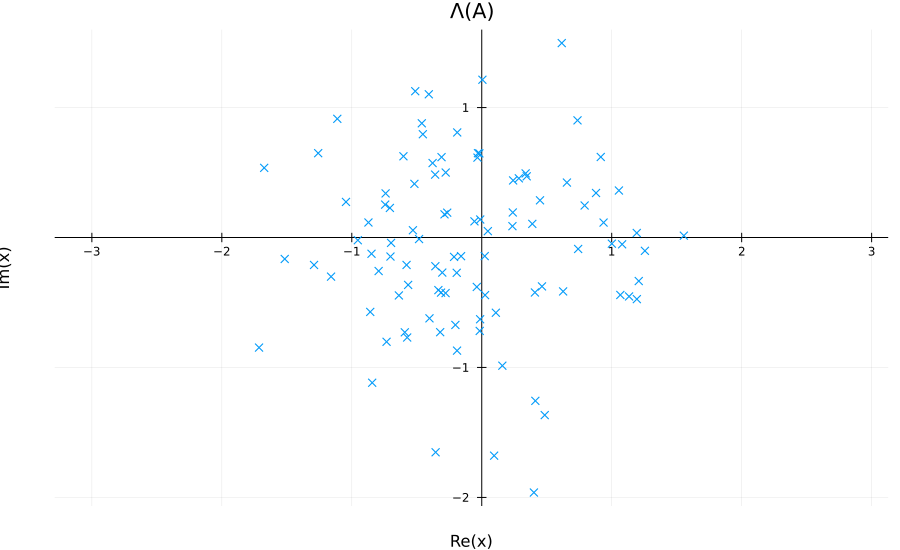

In [11]:
m = 100
Λ = randn(Complex{Float64}, m)
p = plot(Λ, st=:scatter, framestyle=:origin, aspect_ratio = :equal, title = "Λ(A)", m=:x)

In [12]:
Q = qr(randn(Complex{Float64}, m, m)).Q
A = Q * Diagonal(Λ) * Q';
b = randn(m);

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/arnoldi-normal.gif")
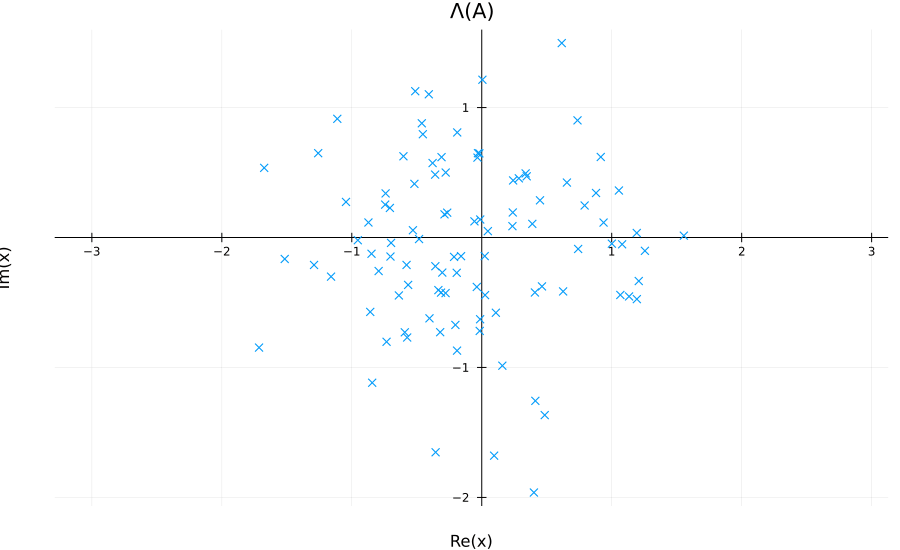

In [13]:
anim = Animation()
frame(anim, p)
for n in 1:20
    q = deepcopy(p)
    _, H̃ = arnoldi(A, b, n)
    Θ = eigvals(H̃[1:n,1:n])
    plot!(q, Θ, st=:scatter, c=2, m=:diamond, title = "Λ(A), Λ(H($n))")
    frame(anim, q)
end
gif(anim, "arnoldi-normal.gif", fps=0.5)

- Ritz values appear to be converging to **extremal eigenvalues of $A$**

### Experiment 2: random non-normal matrices

$$Q (\Lambda + \alpha R) Q^*$$

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/arnoldi-non-normal.gif")
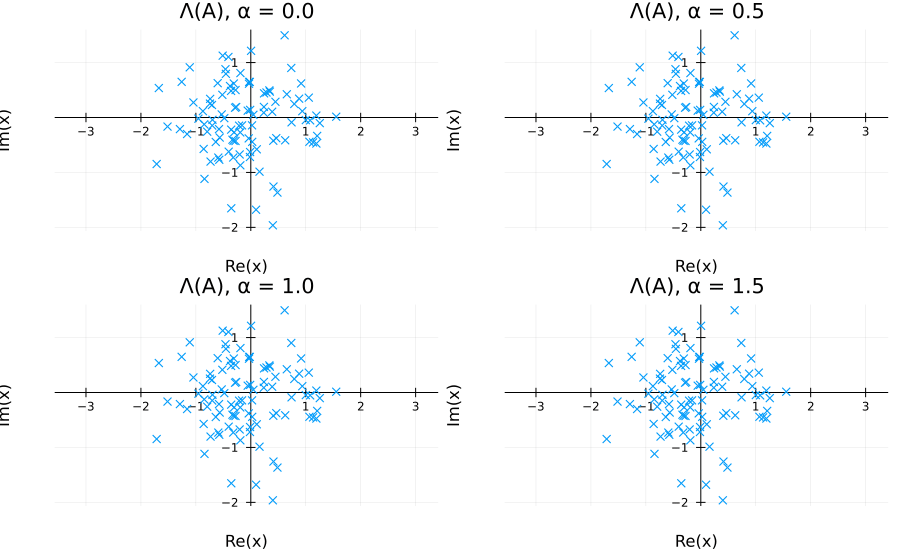

In [14]:
αs = LinRange(0.0,1.5,4)
anim = Animation()
q = [plot(p, title="Λ(A), α = $α") for α in αs]
R = triu(randn(m,m))
R = Matrix(R - Diagonal(R))
frame(anim, plot(q..., layout=(2,2)))
for n in 1:20
    for (i,α) in enumerate(αs)
        _, H̃ = arnoldi(Q * (Diagonal(Λ) + α * R) * Q', b, n)
        Θ = eigvals(H̃[1:n,1:n])
        q[i] = plot(p,Θ, st=:scatter, c=2, m=:diamond, title = "Λ(A), α=$α, Λ(H($n))" )
    end
    frame(anim, plot(q..., layout=(2,2)))
end
gif(anim, "arnoldi-non-normal.gif", fps=1)

- The **farther the matrix is from normal**, the less the Ritz values look like eigenvalues

### $\Lambda(A)$ (computed) vs. $\Lambda$

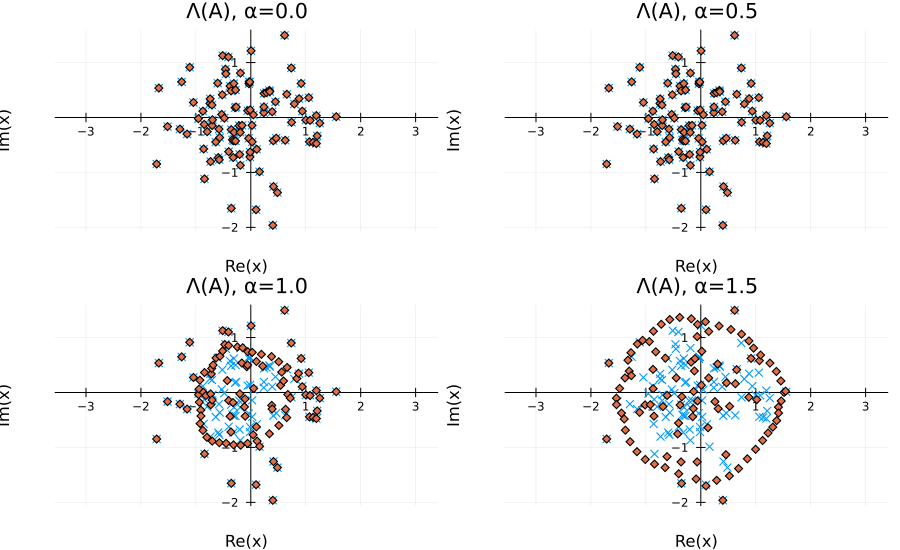

In [15]:
αs = LinRange(0.0,1.5,4)

for (i,α) in enumerate(αs)
    Θ = eigvals(Q * (Diagonal(Λ) + α * R) * Q')
    q[i] = plot(p,Θ, st=:scatter, c=2, m=:diamond, title = "Λ(A), α=$α" )
end
plot(q..., layout=(2,2))

- **The eigenvalues themselves** are more ill-conditioned the farther $A$ is from normal

###  Arnoldi and Polynomial Approximation

By last week's exercise, each $x \in \mathcal{K}_n$ is

$$x = c_0 b + c_1 A b + c_2 A^2 b + \cdots + c_{n-1} A^{n-1} b = q(A)b,$$

for some polynomial $q$ with degree $\leq n-1$.

Krylov subspaceiterations can be analyzed in terms of matrix polynomials.

### Monic polynomials

$$\large P^n = \{\text{monic polynomials of degree } n\}.$$

(monic: leading coefficient is 1.)

### Arnoldi Approximation Problem

Find $p^n \in P^n$ such that

$$\large p^n = \arg\min_{q\in P^n} \| q(A) b\|_2.$$

### Arnoldi Approximation Problem $\Leftrightarrow$ Ritz values

**T&B Theorem 34.1.** As long as the Arnoldi iteration does not break down ($K_n$ is full rank), the unique minimizer of the Arnoldi approximation problem is the characteristic polynomial of $H_n$.

_Proof._

For every $q$, $q(A)b \in \mathcal{K}_{n+1}(A,b) \Rightarrow q(A)b = A^n b - Q_n y$ for some $y$.

$$\|q(A)b\|_2 = \|\underbrace{A^n b - Q_n y}_{q(A)b}\|_2$$

Looks like a least squares problem, with residual $q(A)b$ and solution subspace $\mathcal{K}_n$.

$\Rightarrow$ $q(A)$ is the solution if and only if the residual is orthogonal to the solution subspace,

$$Q_n^* p^n(A) b = 0.$$

Let the final $Q_m = [Q_n | U]$, then $A = Q_m H_m Q_m^*$, and

$$Q_n^* p^n(A) b = Q_n^* p^n(Q_m H Q_m^*) b = Q_n^* Q_m p^n(H) Q_m^* b = [I | 0] p^n(H) e_1.$$

In other words: $p^n(H)$ is the minimizer if and only if the first $n$ values in the first column of $p^n(H)$ are zero.

Because $H$ is upper-Hessenberg, this is true if and only if the first column of $p^n(H_n)$ is zero.

Because Arnoldi didn't break down (by assumption) $\Leftrightarrow p^n(H_n) = 0$.

### Aside: polynomials such that $p(A) = 0$.

- Always true for the characteristic polynomial of $A$.
- If $p(A) = 0$ then every eigenvalue of $A$ must be a root of $A$.

- But just because every eigenvalue of $A$ is a root of $p$ does not mean $p(A) = 0$.  Countexample:

$$A = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}, \quad p(A) = (I - A) = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}.$$

(An important fact for a homework problem.)

- The smallest polynomial such that $p(A) = 0$ is the _minimal polynomial_ of $A$.

### Back to the proof

- Arnoldi didn't break down (by assumption) $\Leftrightarrow$ the characteristic polynomial of $H_n$ is its minimal polynomial $\Leftrightarrow$ $p^n$ is the characteristic polynomial of $H_n$.

## Ritz Value Invariance Properties

They have many of same invariance properties of eigenvalues themselves

### 1. Translation Invariance

If $A$ is changed to $A + \sigma I$ and $b$ is left unchanged, the Ritz values $\{\theta_j\}$ change to $\{\theta_j + \sigma\}$.

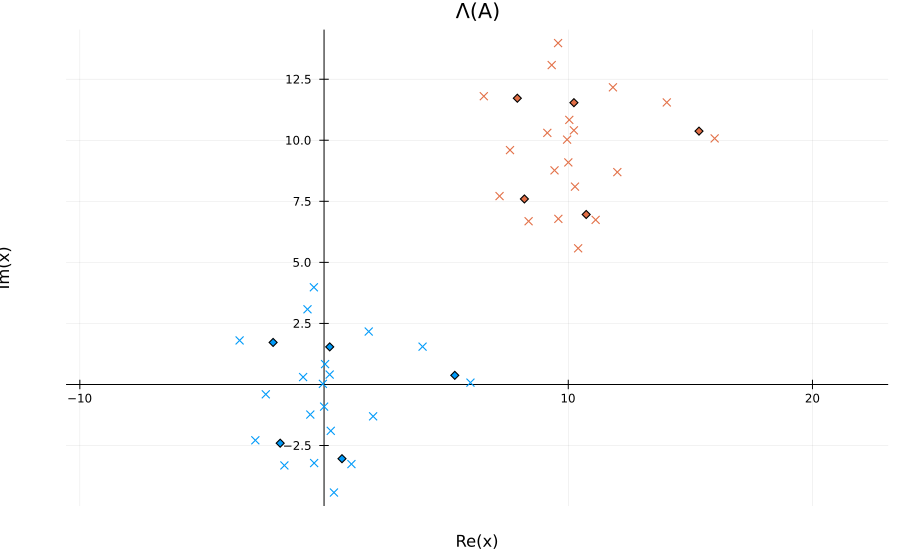

In [16]:
m = 20
Λ = randn(Complex{Float64}, m)
Q, R = qr(randn(Complex{Float64}, m, m))
Q, _ = qr(randn(Complex{Float64}, m, m))
A = Q * Diagonal(Λ) * R * Q'
σ = 10(1 + 1im)
p = plot([eigvals(A)  eigvals(A + σ * I)], st=:scatter, framestyle=:origin, aspect_ratio = :equal, title = "Λ(A)", m=:x, c=[1 2])
n = 5
b = randn(Complex{Float64}, m)
Q, H = arnoldi(A, b, n)
Qσ, Hσ = arnoldi(A + σ * I, b, n)
Θ = eigvals(H[1:n,1:n])
Θσ = eigvals(Hσ[1:n, 1:n])
plot!(p, [Θ Θσ], st=:scatter, m=:diamond, c=[1 2])

### 2. Scale Invariance

If $A$ is changed to $\sigma A$ and $b$ is left unchanged, the Ritz values $\{\theta_j\}$ change to $\{\sigma \theta_j\}$.

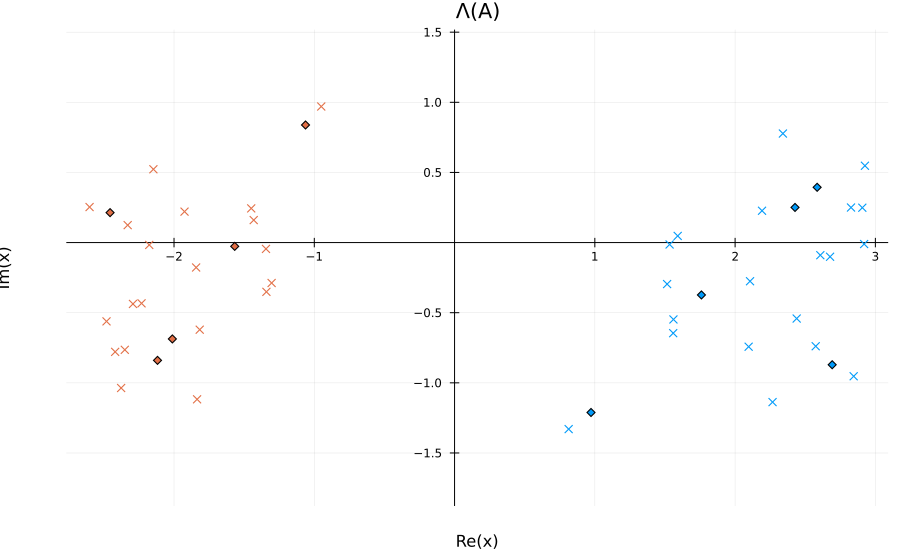

In [17]:
m = 20
Λ = 2 .+ randn(Complex{Float64}, m)
Q, _ = qr(randn(Complex{Float64}, m, m))
A = Q * Diagonal(Λ) * Q'
σ = randn(Complex{Float64})
p = plot([eigvals(A)  eigvals(σ * A)], st=:scatter, framestyle=:origin, aspect_ratio = :equal, title = "Λ(A)", m=:x, c=[1 2])
n = 5
b = randn(Complex{Float64}, m)
Q, H = arnoldi(A, b, n)
Qσ, Hσ = arnoldi(σ * A, b, n)
Θ = eigvals(H[1:n,1:n])
Θσ = eigvals(Hσ[1:n, 1:n])
plot!(p, [Θ Θσ], st=:scatter, m=:diamond, c=[1 2])

### 3. Unitary Invariance

If $A$ is changed to $U A U^*$ and $b$ is changed to $U^* b$, the Ritz values $\{\theta_j\}$ are unchanged.

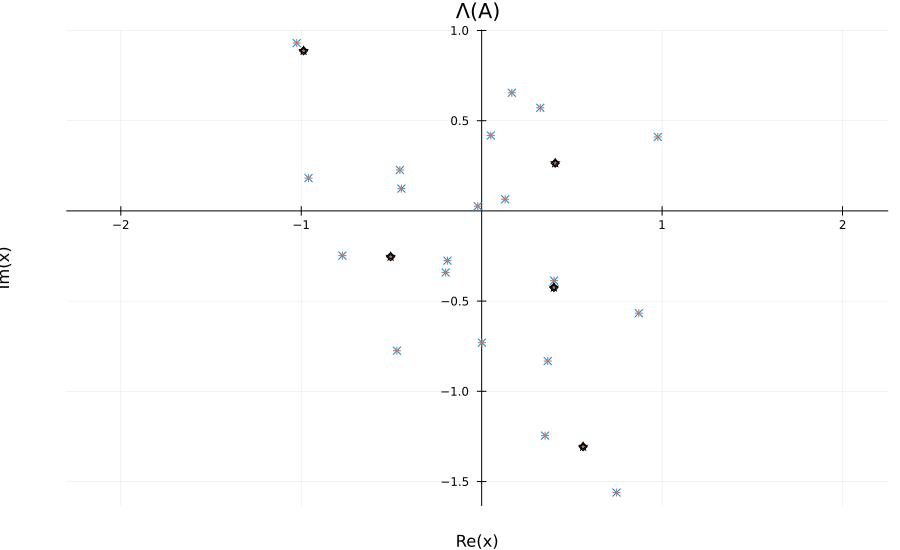

In [18]:
m = 20
Λ = randn(Complex{Float64}, m)
Q, _ = qr(randn(Complex{Float64}, m, m))
U, _ = qr(randn(Complex{Float64}, m, m))
A = Q * Diagonal(Λ) * Q'
p = plot([eigvals(A)  eigvals(U * A * U')], st=:scatter, framestyle=:origin, aspect_ratio = :equal, title = "Λ(A)", m=[:x :+], c=[1 2])
n = 5
b = randn(Complex{Float64}, m)
Q, H = arnoldi(A, b, n)
Qσ, Hσ = arnoldi(U * A * U', U * b, n)
Θ = eigvals(H[1:n,1:n])
Θσ = eigvals(Hσ[1:n, 1:n])
plot!(p, [Θ Θσ], st=:scatter, m=[:diamond :star], c=[1 2])

### Ritz vectors

The eigenvectors of $H_n$ are the **Ritz vectors**.  In all three of the above cases, the Ritz vectors do not change.

### Numerical Example 3: Observed convergence rate of Ritz values to eigenvalues

All eigenvalues are evenly distributed in the unit disk except for one outlier, $l = 1.5$

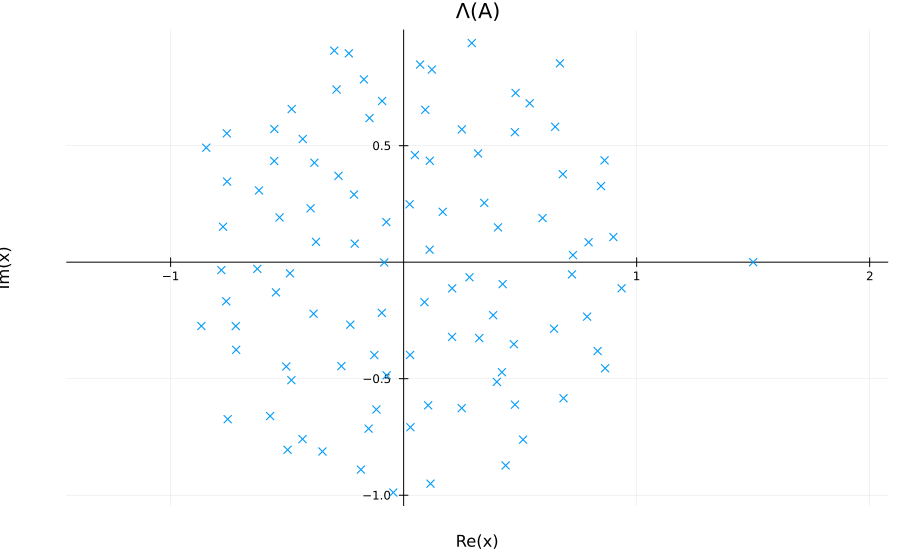

In [19]:
m = 100
Λ = eigvals(randn(Complex{Float64}, m, m) / sqrt(m))
l = 1.5
Λ[1] = l
plot(Λ, st=:scatter, framestyle=:origin, aspect_ratio = :equal, title = "Λ(A)", m=:x)

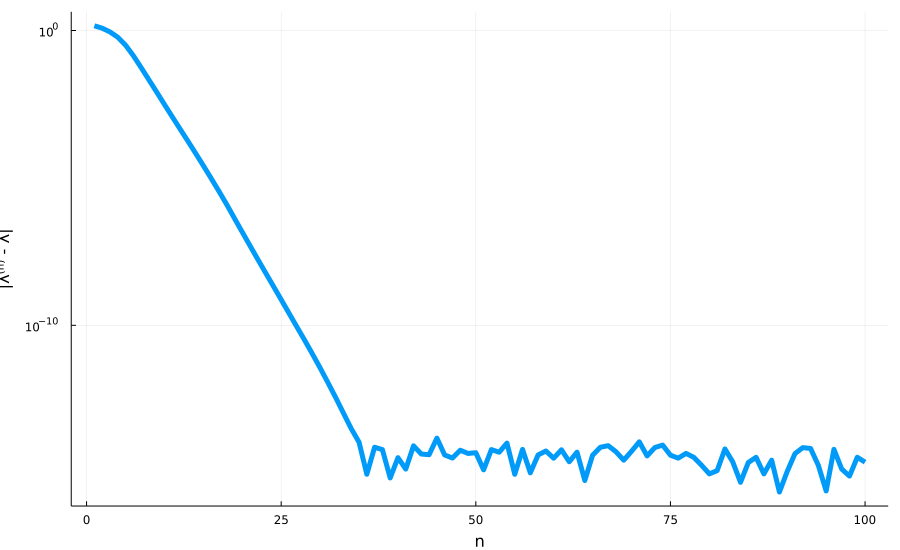

In [20]:
Q = qr(randn(Complex{Float64}, m, m)).Q
A = Q * Diagonal(Λ) * Q'
λs = Complex{Float64}[]
b = randn(Complex{Float64}, m)
for n in 1:m
    _, H = arnoldi(A, b, n)
    Θ = eigvals(H[1:n,1:n])
    j = argmin(abs.(Θ .- l))
    push!(λs, Θ[j])
end
λs
p = plot(max.(eps(),abs.(λs .- l)), yscale=:log10, xlabel="n", ylabel="|λ⁽ⁿ⁾ - λ|")
#plot!(p, [1, 25], [1, (2/3)^25], l=(:dash, :black))

Now make the outlier $l = 2$

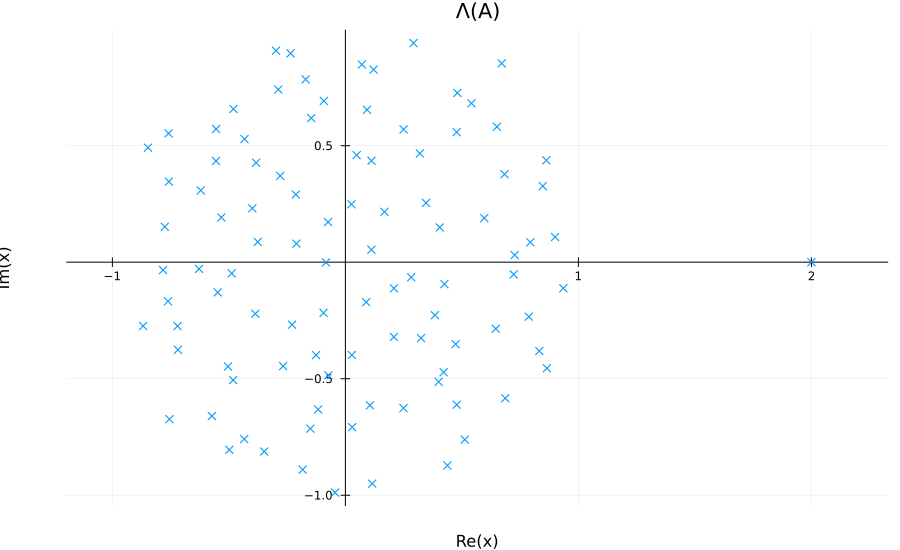

In [21]:
l = 2
Λ[1] = l
plot(Λ, st=:scatter, framestyle=:origin, aspect_ratio = :equal, title = "Λ(A)", m=:x)

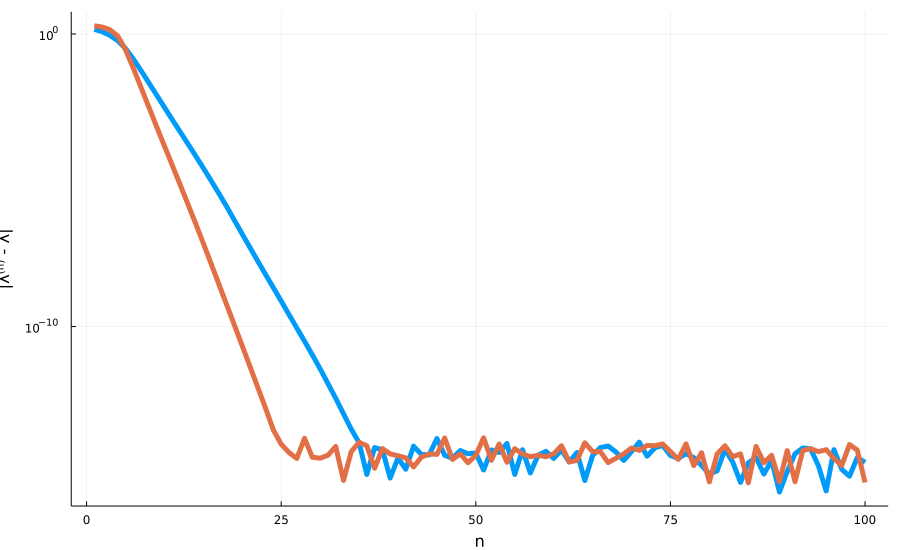

In [22]:
A = Q * Diagonal(Λ) * Q'
λs = Complex{Float64}[]
b = randn(Complex{Float64}, m)
for n in 1:m
    _, H = arnoldi(A, b, n)
    Θ = eigvals(H[1:n,1:n])
    j = argmin(abs.(Θ .- l))
    push!(λs, Θ[j])
end
λs
plot!(p, max.(eps(),abs.(λs .- l)))

### Observations (not a proof)

- Ritz values appear to **converge linearly** to eigenavalues

- The convergence rate is affected by **the separation of $\lambda$ from other eigenvalues**